In [34]:
# Parameters for this script
num_features={"waveclus": 10, "PCA":2, "UMAP":2}    # Optimal dimmensionality
fscore_results={}         # dictionary where results will be saved
confmat_results={}         # dictionary where results will be saved
delta=2                    # Parameter to indicate if both spikes are the same shifted in samples 
min_features=2            # Minimimum dimensionality or # of components to explore.
maximum_features=15       # Maximum dimensionality to explore


#--------------------------------------------------------------------------------------------------------------
# importing libraries
import numpy as np
from scipy.io import loadmat
#import spikeforest as sf
import matplotlib.pyplot as plt
#from busz_funcs import pk, pts_extraction, butter_bandpass_filter_zi, load_kachery
#from toposort.preprocessing import spike_denoiser as denoiser, spike_aligner as aligner
import umap
import hdbscan
from scipy.spatial.distance import cdist
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA 
#from quiroga import *
from matplotlib.colors import ListedColormap
import matplotlib.gridspec as gridspec
import random
#import umap.plot
import pywt
from scipy import stats
import pickle as pkl        # probably Vik needs to install this library, 
import SpkSort as s
from os import path as p
from os import listdir
#plt.style.use('fivethirtyeight')
plt.rcParams['svg.fonttype'] = 'none'     # Export svg text as text and not paths!

# FOr silencing warnings
import warnings
warnings.filterwarnings("ignore")


#
path="/media/sparra/HDD/article_spike_sorting/Simulator/"
namefile, noiselevel= ("C_Difficult2_noise015.mat", 0.15)

gt:  3
clas:  3


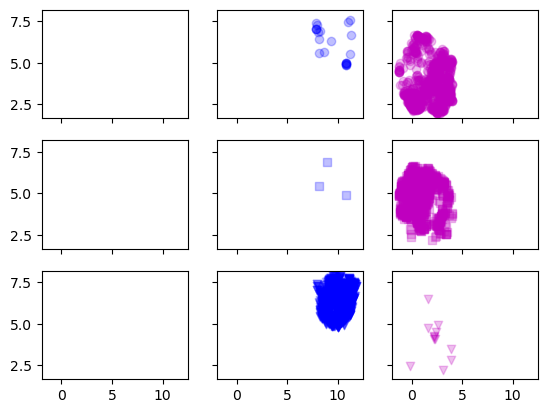

It's done


In [35]:
spikes, labels, spike_times = s.load_quiroga_spikes(p.join(path, namefile) )  
clusters=np.unique(labels)
denoised = s.denoiser(spikes)
spikes2 = s.aligner(denoised, alignment="tukey", window_length=30, upsample_rate=8)
# Calculating values with the whole set
reducer_waveclus = s.waveclus(spikes2, maximum_features)
reducer_pca= PCA(maximum_features).fit_transform(spikes2)
clasification={}          # 
scorer={}
for dim_i in range(min_features, maximum_features):
    if dim_i!=2:
        continue
    clusterer_waveclus= hdbscan.HDBSCAN(min_cluster_size=30, min_samples=5, cluster_selection_epsilon=.6).fit(reducer_waveclus[:, 0:dim_i])
    clasification["waveclus"]= clusterer_waveclus.labels_
    #  sep per technique
    clusterer_pca= hdbscan.HDBSCAN(min_cluster_size=30, min_samples=5, cluster_selection_epsilon=.6).fit(reducer_pca[:, 0:dim_i])
    clasification["pca"]= clusterer_pca.labels_
    
    reducer_umap= umap.UMAP(min_dist=0, n_neighbors=10, n_components=dim_i, n_epochs=2000, random_state=0, metric="manhattan").fit(spikes2)
    umap_emb = reducer_umap.embedding_.copy()
    clusterer_umap = hdbscan.HDBSCAN(min_cluster_size=30, min_samples=5, cluster_selection_epsilon=.6).fit(reducer_umap.embedding_)
    clasification["umap"] = clusterer_umap.labels_
    # Now measure f-score per file and technique
    # raise ValueError("Aqui vamos")
    # Plotting for exploratory purposes
    c=("r", "b", "m", "g", "y")
    marker=("o", "s", "v", "P")
    gt_labels=np.unique(labels)
    clas_labels=np.unique(clasification["pca"])
    fig, ax=plt.subplots(len(gt_labels), len(clas_labels), sharex=True, sharey=True)
    print("gt: ", len(gt_labels))
    print("clas: ", len(clas_labels))
    for idx_gt, gt_i in enumerate(gt_labels):
        for idx_clas, clas_i in enumerate(clas_labels):
            choice=np.logical_and(clusterer_umap.labels_==clas_i, labels==gt_i )
            ax[idx_gt, idx_clas].scatter(umap_emb[choice, 0], umap_emb[choice, 1], c=c[idx_clas], 
                        marker=marker[idx_gt], alpha=0.25)
    plt.show(block=False)
    
    for technique_i in clasification.keys():
        fscore_tmp, incl_val, matrix, inclusion_mat =s.f_recording2(spike_times, labels, clasification[technique_i], delta, return_conf_mat=True)
        if dim_i==min_features:
            scorer[technique_i]=[(fscore_tmp, matrix, inclusion_mat)]
        else:
            scorer[technique_i].append((fscore_tmp, matrix, inclusion_mat))
print("It's done")

In [27]:
scorer

{'waveclus': [(0.5580989275893028,
   array([[0.01545254, 0.        , 0.66541776],
          [0.        , 1.        , 0.        ],
          [0.00887902, 0.        , 0.66516517]]),
   array([[0.32209243, 0.        , 0.74637123],
          [0.        , 1.        , 0.        ],
          [0.18406537, 0.        , 0.74747096]]))],
 'pca': [(0.2908108108108108,
   array([[0.37668552, 0.        , 0.44      ],
          [0.41107746, 0.        , 0.40909091],
          [0.43243243, 0.17060637, 0.29689737]]),
   array([[0.39610172, 0.        , 0.4498018 ],
          [0.4310118 , 0.        , 0.41740085],
          [0.45528986, 0.54662921, 0.30376474]]))],
 'umap': [(0.983594238890209,
   array([[0.00443459, 0.00228441, 0.97585071],
          [0.99669604, 0.        , 0.00218103],
          [0.        , 0.97823597, 0.03962576]]),
   array([[0.00443486, 0.00228554, 0.97615182],
          [0.99669724, 0.        , 0.00218128],
          [0.        , 0.97860706, 0.03964219]]))]}

[[0.65413239 0.02564103]
 [0.66614297 0.00335758]
 [0.00917081 0.9795479 ]]
[0 1]


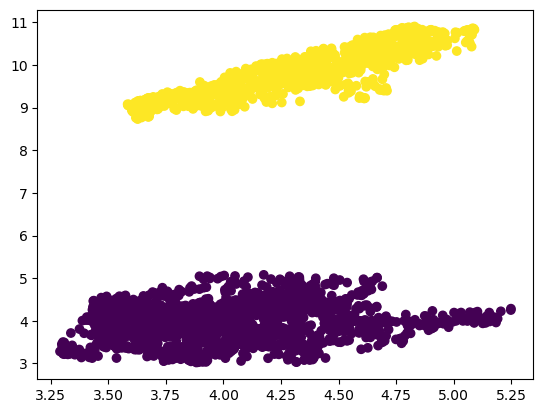

In [37]:
#spikes, labels, spike_times = s.load_quiroga_spikes(p.join(path, namefile) )  
#clusters=np.unique(labels)
#denoised = s.denoiser(spikes)
#spikes2 = s.aligner(denoised, alignment="tukey", window_length=30, upsample_rate=8)
reducer_umap= umap.UMAP(min_dist=0, n_neighbors=10, n_components=6, n_epochs=2000, random_state=0, metric="manhattan").fit(spikes2)
clusterer_umap = hdbscan.HDBSCAN(min_cluster_size=30, min_samples=5, cluster_selection_epsilon=0.6).fit(reducer_umap.embedding_)
plt.scatter(reducer_umap.embedding_[:, 1], reducer_umap.embedding_[:, 0], c=clusterer_umap.labels_)
fscore_tmp, incl_val, matrix, inclusion_mat =s.f_recording2(spike_times, labels, clusterer_umap.labels_, delta, return_conf_mat=True)
print(matrix)
print(np.unique(clusterer_umap.labels_))

array([[0.40205656, 0.0145749 , 0.45234568],
       [0.15995872, 0.        , 0.68979187],
       [0.53857641, 0.56658968, 0.01244615]])

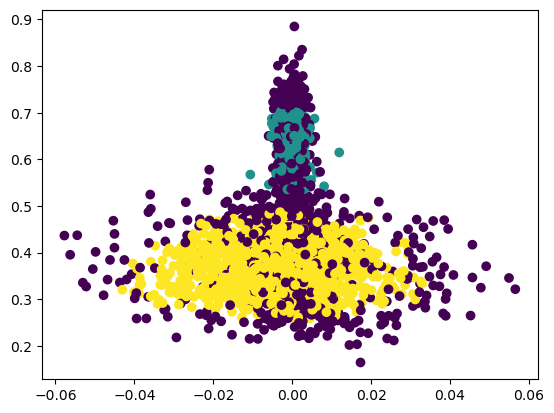

In [36]:
clusterer_wav = hdbscan.HDBSCAN(min_cluster_size=55, min_samples=70, cluster_selection_epsilon=0.35).fit(reducer_waveclus[:, 0:5])
plt.scatter(reducer_waveclus[:, 0], reducer_waveclus[:, 1], c=clusterer_wav.labels_)
fscore_tmp, incl_val, matrix, inclusion_mat =s.f_recording2(spike_times, labels, clusterer_wav.labels_, delta, return_conf_mat=True)
matrix

## Generation of a better method for estimating an overall performance value

In [58]:
A=np.array([[0.1816839 , 0.64546226, 0.        , 0.15],
          [0.29522431, 0.1335289, 0.86486486,   0.05],
          [0.2143928 , 0.60650128, 0.15518987,   0.08]])
rows=[0, 1, 2]
cols=np.argmax(A, axis=1)
indexes=np.flip(np.argsort([A[rows[i], cols[i]] for i in range(3)]))
B=A[indexes]
cols2=np.argmax(B, axis=1)
values=[]
count=0
print("B: ,", B, "cols: ", cols2)
for i in range(len(cols2)):
    if not cols2[i] in values:
        values.append(cols2[i])
        count+=B[rows[i], cols2[i]]
    else:
        purge=np.setdiff1d(rows, values, assume_unique=False)
        count+=np.max(B[rows[i]][purge] )
        values.append(np.argmax(purge))
count/=3
print(count, values,)

B: , [[0.29522431 0.1335289  0.86486486 0.05      ]
 [0.1816839  0.64546226 0.         0.15      ]
 [0.2143928  0.60650128 0.15518987 0.08      ]] cols:  [2 1 1]
0.5749066399999999 [2, 1, 0]


In [59]:
def overall_calc(matrix):
    """
        Assume rows ground truth, columns clustering
    """
    r, c=np.shape(matrix)
    ind=np.argmax(matrix, axis=0)
    rows=np.arange(r)  # in testing [0, 1, 2]
    cols=np.argmax(matrix, axis=1)
    indexes=np.flip(np.argsort([matrix[rows[i], cols[i]] for i in range(3)]))
    B=matrix[indexes]
    cols2=np.argmax(B, axis=1)
    values=[]
    count=0
    print("B: ,", B, "cols: ", cols2)
    for i in range(len(cols2)):
        if not cols2[i] in values:
            values.append(cols2[i])
            count+=B[rows[i], cols2[i]]
        else:
            purge=np.setdiff1d(np.arange(c), values, assume_unique=False)
            count+=np.max(B[rows[i]][purge] )
            values.append(np.argmax(purge))
    count/=3
    return count

overall_calc(A)

B: , [[0.29522431 0.1335289  0.86486486 0.05      ]
 [0.1816839  0.64546226 0.         0.15      ]
 [0.2143928  0.60650128 0.15518987 0.08      ]] cols:  [2 1 1]


0.5749066399999999

In [119]:
run "inclusion_index_drifting_bursting.py"

Executing drifting files
	Analyzing C_Drift_Easy2_noise015.mat file
Executing bursting files
	Analyzing C_Burst_Easy2_noise015.mat file
Finished...


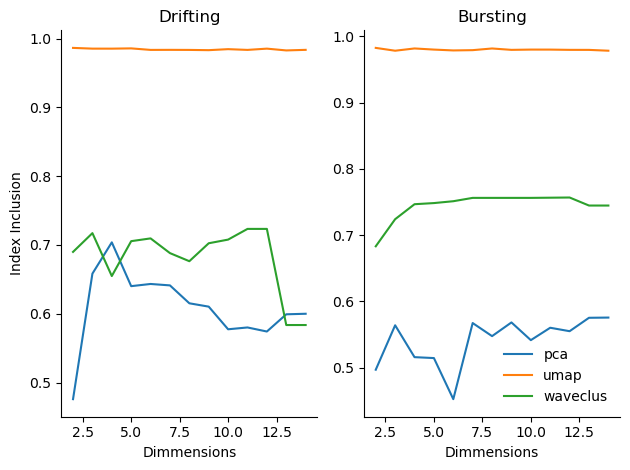

In [121]:
run "plotting_burstingYdrifting_inclusionindex.py"

In [50]:
run "inclusion_index_global.py"

Executing easy files
	Analyzing C_Easy1_noise01.mat file
	Analyzing C_Easy1_noise02.mat file
	Analyzing C_Easy1_noise005.mat file
	Analyzing C_Easy1_noise015.mat file
Executing difficult1 files
	Analyzing C_Difficult1_noise01.mat file
	Analyzing C_Difficult1_noise02.mat file
	Analyzing C_Difficult1_noise005.mat file
	Analyzing C_Difficult1_noise015.mat file
Executing difficult2 files
	Analyzing C_Difficult2_noise01.mat file
	Analyzing C_Difficult2_noise02.mat file
	Analyzing C_Difficult2_noise005.mat file
	Analyzing C_Difficult2_noise015.mat file
Finished...


In [51]:
# Dimmensions vs scores
import subprocess
import numpy as np

file_i ="Analysis_from_2_to_15_pca_wav_incl_index_UMAP_30_new_method.pkl"   # Name of file

subprocess.run(['python', 'Plotting_dimmensions_vs_scores.py', file_i])


Figure(640x480)
Figure(640x480)
Figure(640x480)


CompletedProcess(args=['python', 'Plotting_dimmensions_vs_scores.py', 'Analysis_from_2_to_15_pca_wav_incl_index_UMAP_30_new_method.pkl'], returncode=0)

In [24]:
# Boxplot calculations
import subprocess
import numpy as np
file_i ="Analysis_from_2_to_15_pca_wav_incl_index_UMAP_30_new_method.pkl"   # Name of file
file_j="Difficulty_2_to_15_pca_wav_conf_mat_updated_valuesnn30.pkl"
subprocess.run(['python', 'global_scores.py', file_i, file_j])

Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)


CompletedProcess(args=['python', 'global_scores.py', 'Analysis_from_2_to_15_pca_wav_incl_index_UMAP_30_new_method.pkl', 'Difficulty_2_to_15_pca_wav_conf_mat_updated_valuesnn30.pkl'], returncode=0)

In [15]:
# AUROC calculations
import subprocess
import numpy as np

file_i ="Analysis_from_2_to_15_pca_wav_incl_index_UMAP_30_new_method.pkl"   # Name of file
file_j="Difficulty_2_to_15_pca_wav_conf_mat_updated_valuesnn30.pkl"
nboot="10000"
subprocess.run(['python', 'ROC_scores.py', file_i, file_j, nboot])

Figure(640x480)
################ fscore #######################
Bootstrap: pca, waveclus
AUROC= 0.6045 $$\pm$$ 0.0453, mean=0.6053, nboot:10000

Figure(640x480)
################ fscore #######################
Bootstrap: pca, umap
AUROC= 0.7125 $$\pm$$ 0.0379, mean=0.7131, nboot:10000

Figure(640x480)
################ fscore #######################
Bootstrap: waveclus, umap
AUROC= 0.6703 $$\pm$$ 0.0405, mean=0.6707, nboot:10000

Figure(640x480)
################ Index_Inclusion #######################
Bootstrap: pca, waveclus
AUROC= 0.5844 $$\pm$$ 0.0457, mean=0.5845, nboot:10000

Figure(640x480)
################ Index_Inclusion #######################
Bootstrap: pca, umap
AUROC= 0.6951 $$\pm$$ 0.0352, mean=0.6956, nboot:10000

Figure(640x480)
################ Index_Inclusion #######################
Bootstrap: waveclus, umap
AUROC= 0.6755 $$\pm$$ 0.0421, mean=0.6756, nboot:10000

Figure(640x480)
################ ami #######################
Bootstrap: pca, waveclus
AUROC= 0.5993 $$\pm$$ 0

CompletedProcess(args=['python', 'ROC_scores.py', 'Analysis_from_2_to_15_pca_wav_incl_index_UMAP_30_new_method.pkl', 'Difficulty_2_to_15_pca_wav_conf_mat_updated_valuesnn30.pkl', '10000'], returncode=0)

In [13]:
import pickle as pkl
with open("Difficulty_2_to_15_pca_wav_conf_mat_updated_valuesnn30.pkl", 'rb') as f:
    data=pkl.load(f)
print(data['DaviesBouldin']['C_Easy1_noise01.mat'].keys())
with open ("Analysis_from_2_to_15_pca_wav_incl_index_UMAP_30_new_method.pkl", "rb") as f:
    data2=pkl.load(f)
print(data2["Index_Inclusion"]['C_Easy1_noise01.mat'].keys())

dict_keys(['noise', 'pca', 'umap', 'waveclus'])
dict_keys(['noise', 'pca', 'umap', 'waveclus'])


Why results for difficult 1 with noise at level 0.16 and 0.2 are so strange for umap?
In this dataset, waveclus is better :(

gt:  3
clas:  3


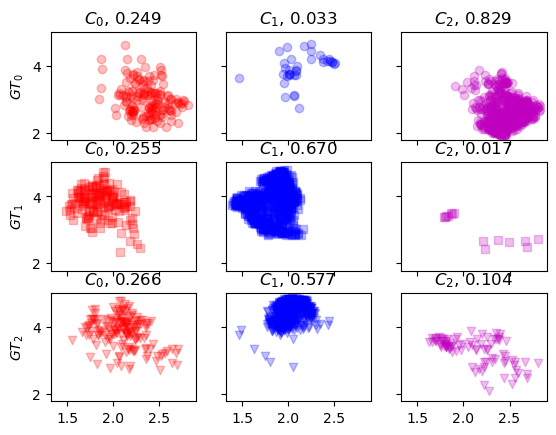

It's done


In [60]:
# Parameters for this script
num_features={"waveclus": 10, "PCA":2, "UMAP":2}    # Optimal dimmensionality
fscore_results={}         # dictionary where results will be saved
confmat_results={}         # dictionary where results will be saved
delta=2                    # Parameter to indicate if both spikes are the same shifted in samples 
min_features=2            # Minimimum dimensionality or # of components to explore.
maximum_features=15       # Maximum dimensionality to explore


#--------------------------------------------------------------------------------------------------------------
# importing libraries
import numpy as np
from scipy.io import loadmat
#import spikeforest as sf
import matplotlib.pyplot as plt
#from busz_funcs import pk, pts_extraction, butter_bandpass_filter_zi, load_kachery
#from toposort.preprocessing import spike_denoiser as denoiser, spike_aligner as aligner
import umap
import hdbscan
from scipy.spatial.distance import cdist
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA 
#from quiroga import *
from matplotlib.colors import ListedColormap
import matplotlib.gridspec as gridspec
import random
#import umap.plot
import pywt
from scipy import stats
import pickle as pkl        # probably Vik needs to install this library, 
import SpkSort as s
from os import path as p
from os import listdir
#plt.style.use('fivethirtyeight')
plt.rcParams['svg.fonttype'] = 'none'     # Export svg text as text and not paths!
# FOr silencing warnings
import warnings
warnings.filterwarnings("ignore")

path="/media/sparra/HDD/article_spike_sorting/Simulator/"
namefile, noiselevel= ("C_Difficult1_noise015.mat", 0.15)


spikes, labels, spike_times = s.load_quiroga_spikes(p.join(path, namefile) )  
clusters=np.unique(labels)
denoised = s.denoiser(spikes)
spikes2 = s.aligner(denoised, alignment="tukey", window_length=30, upsample_rate=8)
# Calculating values with the whole set
reducer_waveclus = s.waveclus(spikes2, maximum_features)
reducer_pca= PCA(maximum_features).fit_transform(spikes2)
clasification={}          # 
scorer={}
for dim_i in range(min_features, maximum_features):
    clusterer_waveclus= hdbscan.HDBSCAN(min_cluster_size=30, min_samples=5, cluster_selection_epsilon=.6).fit(reducer_waveclus[:, 0:dim_i])
    clasification["waveclus"]= clusterer_waveclus.labels_
    #  sep per technique
    clusterer_pca= hdbscan.HDBSCAN(min_cluster_size=30, min_samples=5, cluster_selection_epsilon=.6).fit(reducer_pca[:, 0:dim_i])
    clasification["pca"]= clusterer_pca.labels_
    
    reducer_umap= umap.UMAP(min_dist=0, n_neighbors=100, n_components=dim_i, n_epochs=2000, random_state=0, metric="manhattan").fit(spikes2)
    umap_emb = reducer_umap.embedding_.copy()
    clusterer_umap = hdbscan.HDBSCAN(min_cluster_size=30, min_samples=5, cluster_selection_epsilon=.6).fit(reducer_umap.embedding_)
    clasification["umap"] = clusterer_umap.labels_
    #Now measure f-score per file and technique
    #raise ValueError("Aqui vamos")
    
    for technique_i in clasification.keys():
        fscore_tmp, matrix, inclusion_mat =s.f_recording2(spike_times, labels, clasification[technique_i], delta, return_conf_mat=True)
        if dim_i==min_features:
            scorer[technique_i]=[(fscore_tmp, matrix, inclusion_mat)]
        else:
            scorer[technique_i].append((fscore_tmp, matrix, inclusion_mat))
            # Plotting for exploratory purposes
        if dim_i==8 and technique_i=="umap":
            c=("r", "b", "m", "g", "y")
            marker=("o", "s", "v", "P")
            gt_labels=np.unique(labels)
            clas_labels=np.unique(clasification["pca"])
            fig, ax=plt.subplots(len(gt_labels), len(clas_labels), sharex=True, sharey=True)
            print("gt: ", len(gt_labels))
            print("clas: ", len(clas_labels))
            for idx_gt, gt_i in enumerate(gt_labels):
                ax[idx_gt, 0].set_ylabel("$GT_{%d}$"%(idx_gt))
                for idx_clas, clas_i in enumerate(clas_labels):
                    ax[idx_gt, idx_clas].set_title("$C_{%d}$, %.3f "%(idx_clas, inclusion_mat[idx_gt, idx_clas]))
                    choice=np.logical_and(clusterer_umap.labels_==clas_i, labels==gt_i )
                    ax[idx_gt, idx_clas].scatter(umap_emb[choice, 0], umap_emb[choice, 1], c=c[idx_clas], 
                                marker=marker[idx_gt], alpha=0.25)
        plt.show(block=False)
print("It's done")

In [6]:
pwd

'/media/sparra/HDD/article_spike_sorting'

## Difficulty 

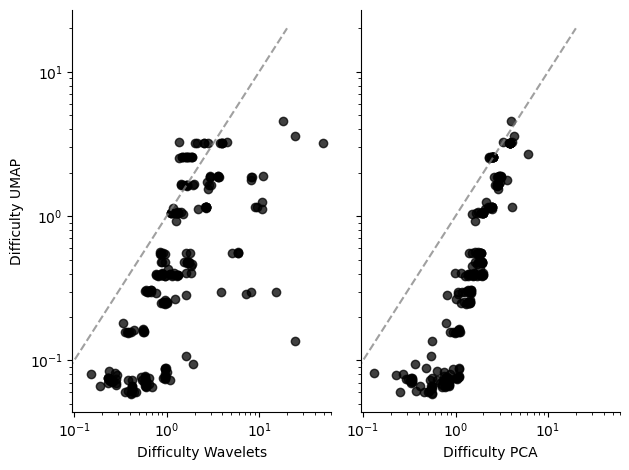

In [8]:
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt

with open("Difficulty_2_to_15_pca_wav_conf_mat_updated_valuesnn30.pkl", 'rb') as f:
    data=pkl.load(f)


data=data["DaviesBouldin"]
dimm=np.arange(2, 15)
dimmpool=[]
difficultipool={"umap":[], "pca":[], "waveclus":[]}
for file_i in data.keys():
    for reducer_i in data[file_i].keys():
        if reducer_i=="noise":
            continue
        difficultipool[reducer_i].append(data[file_i][reducer_i])
    dimmpool.append(dimm)


fig, ax=plt.subplots(1, 2, sharey=True, sharex=True)
x=np.hstack(dimmpool)
ax[0].set_yscale("log")
ax[0].set_xscale("log")
ax[1].set_yscale("log")
ax[1].set_xscale("log")
ax[0].scatter(np.hstack(difficultipool["waveclus"]),np.hstack(difficultipool["umap"]), alpha=0.75, c="k")
ax[1].scatter(np.hstack(difficultipool["pca"]),np.hstack(difficultipool["umap"]), alpha=0.75, c="k")
ax[0].plot(np.linspace(0, 20, 100), np.linspace(0, 20, 100), ls="--", c="gray", alpha=0.75)
ax[1].plot(np.linspace(0, 20, 100), np.linspace(0, 20, 100), ls="--", c="gray", alpha=0.75)

ax[0].set_ylabel("Difficulty UMAP")
ax[0].set_xlabel("Difficulty Wavelets")
ax[1].set_xlabel("Difficulty PCA")
ax[0].spines[['right', 'top']].set_visible(False)
ax[1].spines[['right', 'top']].set_visible(False)
plt.xlim(0, 60)
fig.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'     # Export svg text as text and not paths!
# plt.show(block=False)
fig.savefig("diff_umapvsothers.svg", format="svg")
fig.savefig("diff_umapvsothers.png", format="png", dpi=500)

## How difficulty depends on dimensionality for UMAP

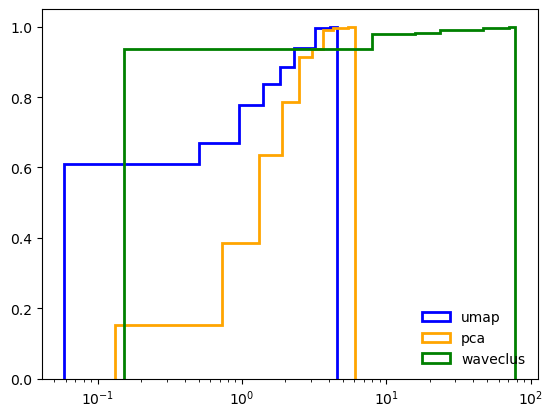

In [24]:
plt.hist(np.vstack(difficultipool["umap"]).flatten(), cumulative=True,
         histtype="step", density=True, color="blue", lw=2, label="umap")
plt.hist(np.vstack(difficultipool["pca"]).flatten(), cumulative=True,
         histtype="step", density=True, color="orange", lw=2, label="pca")
plt.hist(np.vstack(difficultipool["waveclus"]).flatten(), cumulative=True,
         histtype="step", density=True, color="green", lw=2, label="waveclus")
plt.legend(loc="best", frameon=False)


# number of clusters as a function of dimmensions and number of neighbors for UMAP in relation to the real number of clusters.


In [1]:
run "Density by using UMAP.py"

/home/sparra/anaconda3/envs/py11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Executing easy files
	Analyzing C_Easy1_noise01.mat file
	Analyzing C_Easy1_noise02.mat file
	Analyzing C_Easy1_noise005.mat file
	Analyzing C_Easy1_noise015.mat file
Executing difficult1 files
	Analyzing C_Difficult1_noise01.mat file
	Analyzing C_Difficult1_noise02.mat file
	Analyzing C_Difficult1_noise005.mat file
	Analyzing C_Difficult1_noise015.mat file
Executing difficult2 files
	Analyzing C_Difficult2_noise01.mat file
	Analyzing C_Difficult2_noise02.mat file
	Analyzing C_Difficult2_noise005.mat file
	Analyzing C_Difficult2_noise015.mat file
Finished...


In [17]:
run "Nneighbors_umap_Vs_kstest.py"

Executing easy files
	Analyzing C_Easy1_noise01.mat file
	Analyzing C_Easy1_noise02.mat file
	Analyzing C_Easy1_noise005.mat file
	Analyzing C_Easy1_noise015.mat file
Executing difficult1 files
	Analyzing C_Difficult1_noise01.mat file
	Analyzing C_Difficult1_noise02.mat file
	Analyzing C_Difficult1_noise005.mat file
	Analyzing C_Difficult1_noise015.mat file
Executing difficult2 files
	Analyzing C_Difficult2_noise01.mat file
	Analyzing C_Difficult2_noise02.mat file
	Analyzing C_Difficult2_noise005.mat file
	Analyzing C_Difficult2_noise015.mat file
Finished...


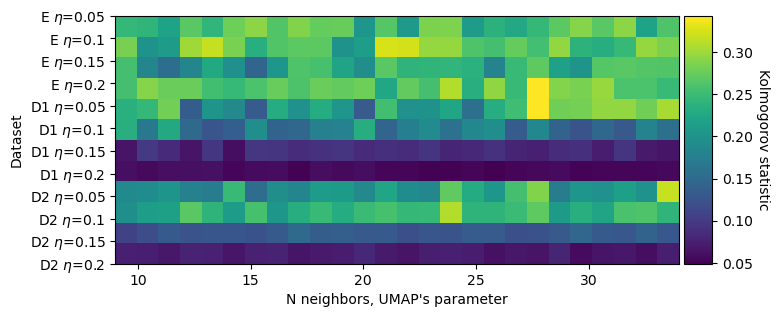

In [3]:
run "plotting_Kneighbors_umap_Vs_ktest.py"

# Drifting and bursting plotting raw data

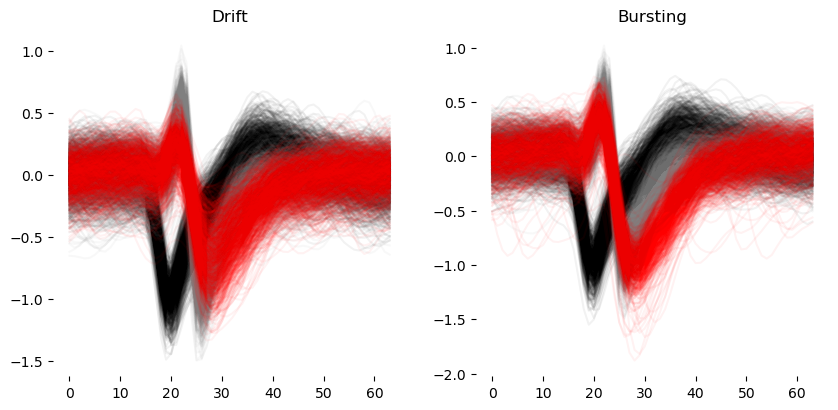

In [22]:
import numpy as np
from scipy.io import loadmat
#import spikeforest as sf
import matplotlib.pyplot as plt
import SpkSort as s
from os import path as p
path="/media/sparra/HDD/article_spike_sorting/Simulator/"
fig, ax=plt.subplots(1, 2, figsize=(10, 4.5))
names=("Drift", "Bursting")
namefile= ("C_Drift_Easy2_noise015.mat", "C_Burst_Easy2_noise015.mat")
for i in range(2):
    spikes, labels, spike_times = s.load_quiroga_spikes(p.join(path, namefile[i]) )  
    clusters=np.unique(labels)
    denoised = s.denoiser(spikes)
    spikes2 = s.aligner(denoised, alignment="tukey", window_length=30, upsample_rate=8)
    c=("k", "gray", "red")
    l=np.flip(np.unique(labels))
    for cl_idx, cl_i in enumerate(l):
        mask=labels==cl_i
        ax[i].plot(spikes[mask, :].T, c=c[cl_idx], alpha=0.05)
    ax[i].set_title(names[i])
    ax[i].spines[["left", "bottom", "top", "right"]].set_visible(False)

fig.savefig("waveforms_drift_burst.png", dpi=500)
fig.savefig("waveforms_drift_burst.svg")

## Noise in the sets

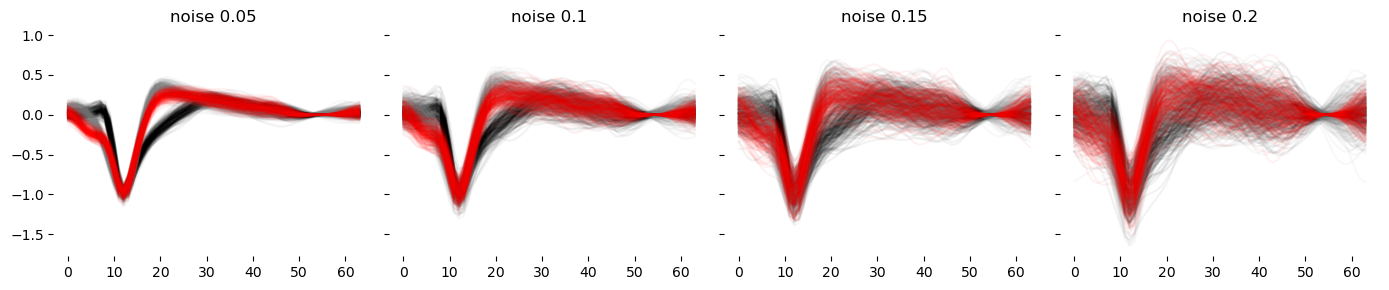

In [2]:
import numpy as np
from scipy.io import loadmat
#import spikeforest as sf
import matplotlib.pyplot as plt
import SpkSort as s
from os import path as p
path="/media/sparra/HDD/article_spike_sorting/Simulator/"
names=("noise 0.05", "noise 0.1", "noise 0.15", "noise 0.2")
namefile= (  "C_Difficult2_noise005.mat",
             "C_Difficult2_noise01.mat",
             "C_Difficult2_noise015.mat",
             "C_Difficult2_noise02.mat",)

fig, ax=plt.subplots(1, len(namefile), figsize=(14, 3), sharex=True, sharey=True)

for i in range(len(namefile)):
    spikes, labels, spike_times = s.load_quiroga_spikes(p.join(path, namefile[i]) )  
    clusters=np.unique(labels)
    denoised = s.denoiser(spikes)
    spikes2 = s.aligner(denoised, alignment="tukey", window_length=30, upsample_rate=8)
    c=("k", "gray", "red")
    l=np.flip(np.unique(labels))
    for cl_idx, cl_i in enumerate(l):
        mask=np.where(labels==cl_i)[0]
        mask2=np.random.choice(mask, size=np.int32(len(mask)//4), replace=False)
        ax[i].plot(spikes2[mask2, :].T, c=c[cl_idx], alpha=0.05)
    ax[i].set_title(names[i])
    ax[i].spines[["left", "bottom", "top", "right"]].set_visible(False)
fig.tight_layout()
fig.savefig("noise_Difficult2.png", dpi=500)
fig.savefig("noise_Difficult2.svg")

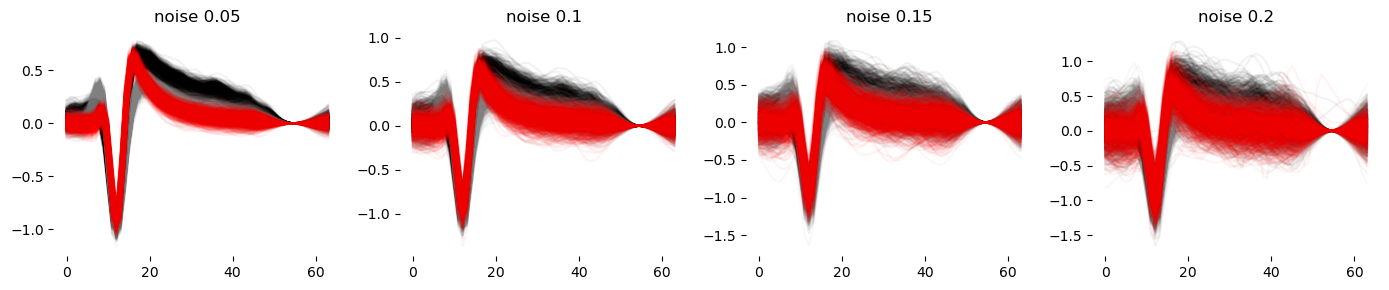

In [32]:
import numpy as np
from scipy.io import loadmat
#import spikeforest as sf
import matplotlib.pyplot as plt
import SpkSort as s
from os import path as p
path="/media/sparra/HDD/article_spike_sorting/Simulator/"
names=("noise 0.05", "noise 0.1", "noise 0.15", "noise 0.2")
namefile= (  "C_Difficult1_noise005.mat",
             "C_Difficult1_noise01.mat",
             "C_Difficult1_noise015.mat",
             "C_Difficult1_noise02.mat",)

fig, ax=plt.subplots(1, len(namefile), figsize=(14, 3))

for i in range(len(namefile)):
    spikes, labels, spike_times = s.load_quiroga_spikes(p.join(path, namefile[i]) )  
    clusters=np.unique(labels)
    denoised = s.denoiser(spikes)
    spikes2 = s.aligner(denoised, alignment="tukey", window_length=30, upsample_rate=8)
    c=("k", "gray", "red")
    l=np.flip(np.unique(labels))
    for cl_idx, cl_i in enumerate(l):
        mask=labels==cl_i
        ax[i].plot(spikes2[mask, :].T, c=c[cl_idx], alpha=0.05)
    ax[i].set_title(names[i])
    ax[i].spines[["left", "bottom", "top", "right"]].set_visible(False)
fig.tight_layout()
fig.savefig("noise_Difficult1.png", dpi=500)
fig.savefig("noise_Difficult1.svg")

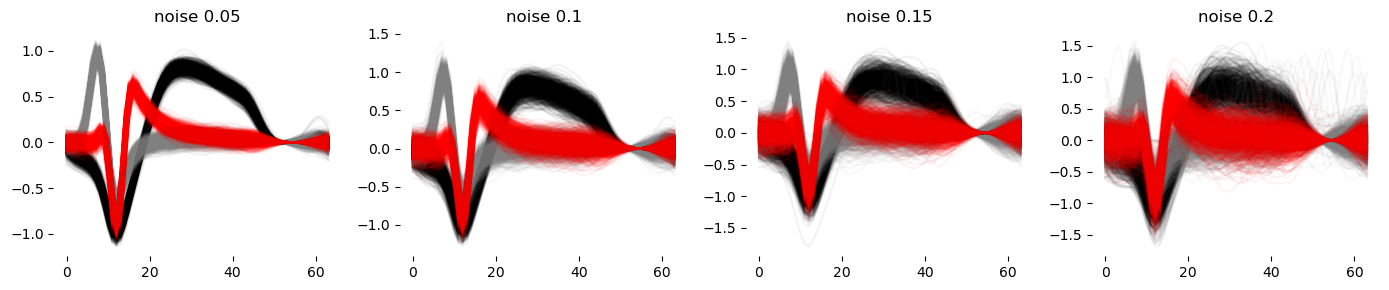

In [33]:
import numpy as np
from scipy.io import loadmat
#import spikeforest as sf
import matplotlib.pyplot as plt
import SpkSort as s
from os import path as p
path="/media/sparra/HDD/article_spike_sorting/Simulator/"
names=("noise 0.05", "noise 0.1", "noise 0.15", "noise 0.2")
namefile= (  "C_Easy1_noise005.mat",
             "C_Easy1_noise01.mat",
             "C_Easy1_noise015.mat",
             "C_Easy1_noise02.mat",)

fig, ax=plt.subplots(1, len(namefile), figsize=(14, 3))

for i in range(len(namefile)):
    spikes, labels, spike_times = s.load_quiroga_spikes(p.join(path, namefile[i]) )  
    clusters=np.unique(labels)
    denoised = s.denoiser(spikes)
    spikes2 = s.aligner(denoised, alignment="tukey", window_length=30, upsample_rate=8)
    c=("k", "gray", "red")
    l=np.flip(np.unique(labels))
    for cl_idx, cl_i in enumerate(l):
        mask=labels==cl_i
        ax[i].plot(spikes2[mask, :].T, c=c[cl_idx], alpha=0.05)
    ax[i].set_title(names[i])
    ax[i].spines[["left", "bottom", "top", "right"]].set_visible(False)
fig.tight_layout()
fig.savefig("noise_Easy1.png", dpi=500)
fig.savefig("noise_Easy1.svg")

## Decimation over difficult datasets with high noise

In [ ]:
import numpy as np
from scipy.io import loadmat
#import spikeforest as sf
import matplotlib.pyplot as plt
import SpkSort as s
from os import path as p
path="/media/sparra/HDD/article_spike_sorting/Simulator/"
names=("noise 0.05", "noise 0.1", "noise 0.15", "noise 0.2")
namefile= (  "C_Difficult2_noise015.mat",
             "C_Difficult2_noise02.mat",)

spikes, labels, spike_times = s.load_quiroga_spikes(p.join(path, namefile[0]) )  
clusters=np.unique(labels)
denoised = s.denoiser(spikes)
spikes2 = s.aligner(denoised, alignment="tukey", window_length=30, upsample_rate=8)

index=np.arange(len(spikes))
np.random.shuffle(index)

for i in range(len(namefile)):
    

    reducer_umap= umap.UMAP(min_dist=0, n_neighbors=100, n_components=dim_i, n_epochs=2000, random_state=0, metric="manhattan").fit(spikes2)
    umap_emb = reducer_umap.embedding_.copy()
    clusterer_umap = hdbscan.HDBSCAN(min_cluster_size=30, min_samples=5, cluster_selection_epsilon=.6).fit(reducer_umap.embedding_)
    clasification["umap"] = clusterer_umap.labels_

In [5]:
data["fscore"].keys()

dict_keys(['C_Easy1_noise01.mat', 'C_Easy1_noise02.mat', 'C_Easy1_noise005.mat', 'C_Easy1_noise015.mat', 'C_Difficult1_noise01.mat', 'C_Difficult1_noise02.mat', 'C_Difficult1_noise005.mat', 'C_Difficult1_noise015.mat', 'C_Difficult2_noise01.mat', 'C_Difficult2_noise02.mat', 'C_Difficult2_noise005.mat', 'C_Difficult2_noise015.mat'])

## Performance averaging difficulty per dimmensionality 

In [6]:
%run "Caller.py"

fscore pca mean:  0.5562825933490105
fscore waveclus mean:  0.659430650873764
fscore umap mean:  0.8223072024111985
Figure(640x480)
Index_Inclusion pca mean:  0.5825026192420134
Index_Inclusion waveclus mean:  0.6774102588932731
Index_Inclusion umap mean:  0.8321719210982607
Figure(640x480)
ami pca mean:  0.547125234716334
ami waveclus mean:  0.6643035697144751
ami umap mean:  0.8154911466103086
Figure(640x480)


## Mean by noise per technique Vs dimmensions

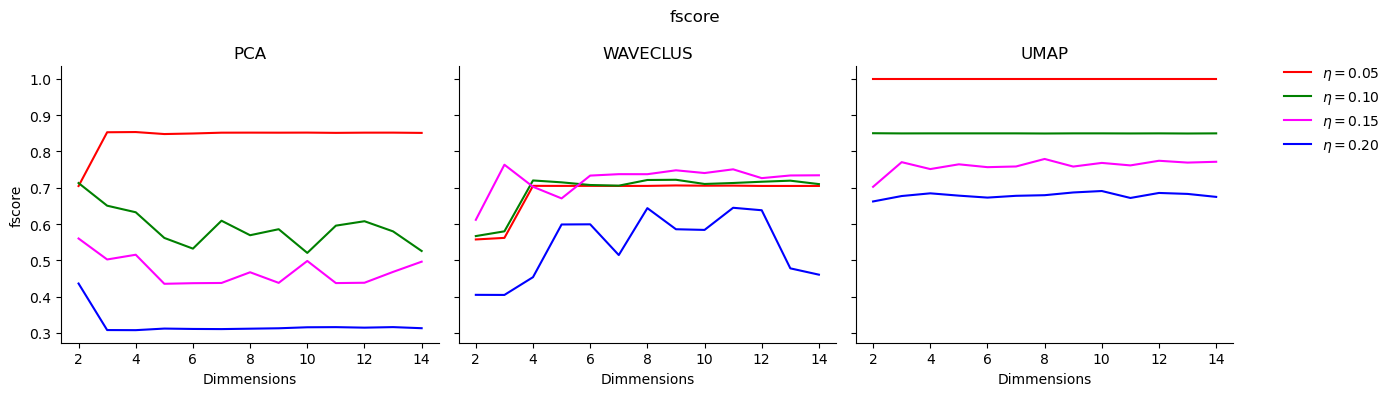

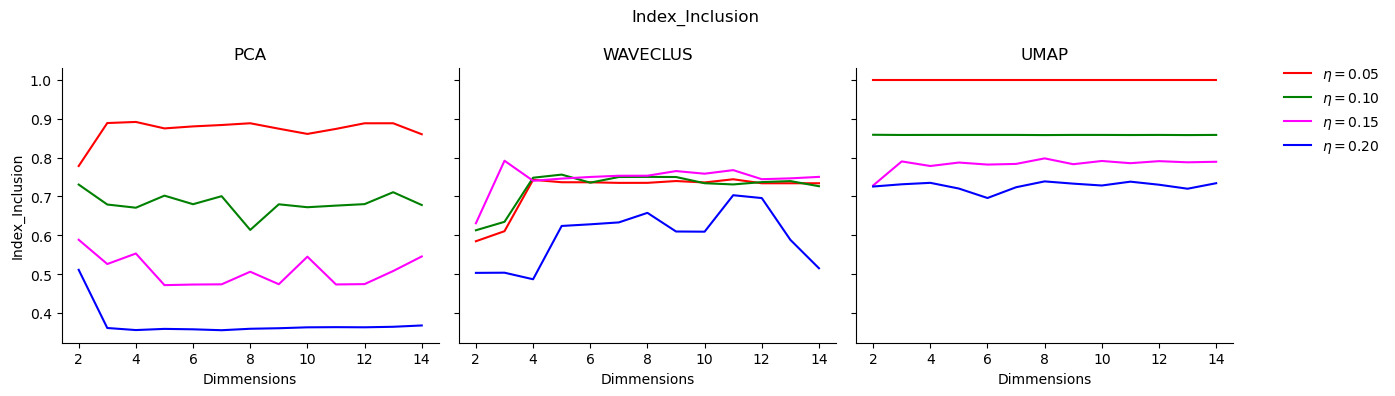

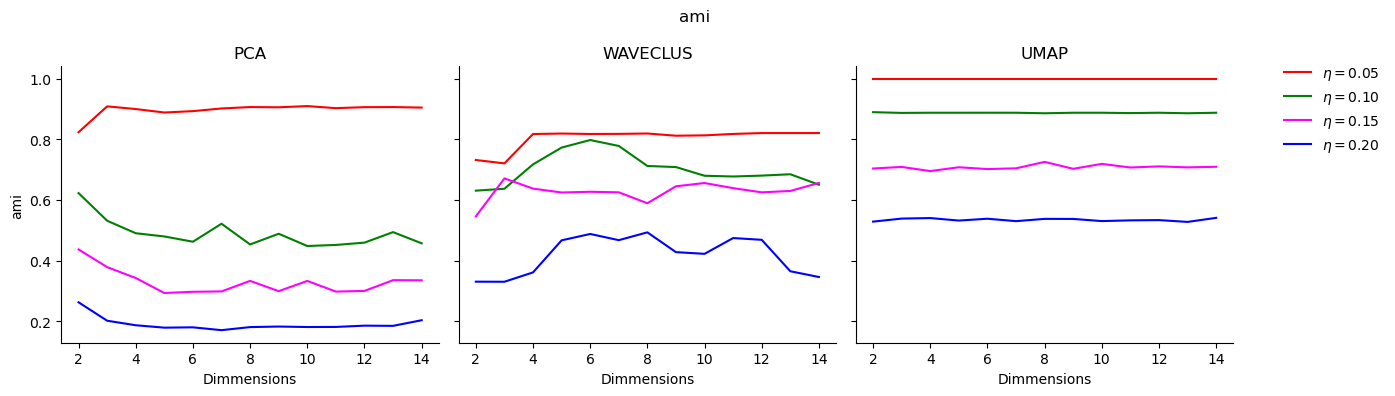

In [12]:
%run 'dimmensions_Vs_Scores_mean_noise.py'